<a href="https://colab.research.google.com/github/Ankan1998/Autoencoders/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import PIL 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 128

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
next(iter(train_dataloader))

In [7]:
latent_dims = 10
capacity = 64

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    c = capacity
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
    self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
    self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)


  def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon


In [8]:
autoencoder=Autoencoder()

In [11]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

In [12]:
from torchsummary import summary
summary(autoencoder,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,088
            Conv2d-2            [-1, 128, 7, 7]         131,200
            Linear-3                   [-1, 10]          62,730
           Encoder-4                   [-1, 10]               0
            Linear-5                 [-1, 6272]          68,992
   ConvTranspose2d-6           [-1, 64, 14, 14]         131,136
   ConvTranspose2d-7            [-1, 1, 28, 28]           1,025
           Decoder-8            [-1, 1, 28, 28]               0
Total params: 396,171
Trainable params: 396,171
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 1.51
Estimated Total Size (MB): 1.81
----------------------------------------------------------------


In [ ]:
def custom_optimizer(optimizer,)

In [31]:
learning_rate = 0.01
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

num_epochs = 100
# set to training mode
autoencoder.train()

train_loss = 0
tot_loss=[]

print('Training ...')
for epoch in tqdm(range(num_epochs)):

    if epoch%20==0:
      optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1
    
    
    train_loss = 0
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)
        
        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss += loss.item()
        
    
        
    tot_loss.append(train_loss)
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss))




  0%|          | 0/100 [00:00<?, ?it/s]

Training ...





  1%|          | 1/100 [00:12<20:07, 12.19s/it]

Epoch [1 / 100] average reconstruction error: 210.183644





  2%|▏         | 2/100 [00:24<19:52, 12.17s/it]

Epoch [2 / 100] average reconstruction error: 64.489660





  3%|▎         | 3/100 [00:36<19:37, 12.14s/it]

Epoch [3 / 100] average reconstruction error: 31.599344





  4%|▍         | 4/100 [00:48<19:30, 12.19s/it]

Epoch [4 / 100] average reconstruction error: 29.139624





  5%|▌         | 5/100 [01:00<19:11, 12.12s/it]

Epoch [5 / 100] average reconstruction error: 27.766664





  6%|▌         | 6/100 [01:12<18:57, 12.10s/it]

Epoch [6 / 100] average reconstruction error: 26.887200





  7%|▋         | 7/100 [01:24<18:40, 12.04s/it]

Epoch [7 / 100] average reconstruction error: 26.284394





  8%|▊         | 8/100 [01:36<18:36, 12.13s/it]

Epoch [8 / 100] average reconstruction error: 25.814814





  9%|▉         | 9/100 [01:48<18:07, 11.95s/it]

Epoch [9 / 100] average reconstruction error: 25.427681





 10%|█         | 10/100 [02:00<17:49, 11.89s/it]

Epoch [10 / 100] average reconstruction error: 25.082191





 11%|█         | 11/100 [02:12<17:39, 11.90s/it]

Epoch [11 / 100] average reconstruction error: 24.806889





 12%|█▏        | 12/100 [02:23<17:25, 11.88s/it]

Epoch [12 / 100] average reconstruction error: 24.613561





 13%|█▎        | 13/100 [02:35<17:09, 11.84s/it]

Epoch [13 / 100] average reconstruction error: 24.400121





 14%|█▍        | 14/100 [02:47<16:53, 11.78s/it]

Epoch [14 / 100] average reconstruction error: 24.224197





 15%|█▌        | 15/100 [02:59<16:48, 11.86s/it]

Epoch [15 / 100] average reconstruction error: 24.103670





 16%|█▌        | 16/100 [03:11<16:29, 11.78s/it]

Epoch [16 / 100] average reconstruction error: 23.925062





 17%|█▋        | 17/100 [03:22<16:19, 11.80s/it]

Epoch [17 / 100] average reconstruction error: 23.815214





 18%|█▊        | 18/100 [03:34<15:52, 11.62s/it]

Epoch [18 / 100] average reconstruction error: 23.701513





 19%|█▉        | 19/100 [03:45<15:29, 11.47s/it]

Epoch [19 / 100] average reconstruction error: 23.607225





 20%|██        | 20/100 [03:56<15:18, 11.48s/it]

Epoch [20 / 100] average reconstruction error: 23.525851





 21%|██        | 21/100 [04:08<15:06, 11.47s/it]

Epoch [21 / 100] average reconstruction error: 22.120159





 22%|██▏       | 22/100 [04:20<15:04, 11.60s/it]

Epoch [22 / 100] average reconstruction error: 21.896507





 23%|██▎       | 23/100 [04:31<15:00, 11.70s/it]

Epoch [23 / 100] average reconstruction error: 21.826730





 24%|██▍       | 24/100 [04:43<14:41, 11.60s/it]

Epoch [24 / 100] average reconstruction error: 21.774978





 25%|██▌       | 25/100 [04:54<14:27, 11.57s/it]

Epoch [25 / 100] average reconstruction error: 21.738513





 26%|██▌       | 26/100 [05:06<14:11, 11.51s/it]

Epoch [26 / 100] average reconstruction error: 21.703577





 27%|██▋       | 27/100 [05:17<13:54, 11.43s/it]

Epoch [27 / 100] average reconstruction error: 21.668000





 28%|██▊       | 28/100 [05:28<13:41, 11.41s/it]

Epoch [28 / 100] average reconstruction error: 21.637690





 29%|██▉       | 29/100 [05:40<13:26, 11.36s/it]

Epoch [29 / 100] average reconstruction error: 21.607245





 30%|███       | 30/100 [05:51<13:20, 11.44s/it]

Epoch [30 / 100] average reconstruction error: 21.580603





 31%|███       | 31/100 [06:02<13:05, 11.38s/it]

Epoch [31 / 100] average reconstruction error: 21.555684





 32%|███▏      | 32/100 [06:14<13:01, 11.49s/it]

Epoch [32 / 100] average reconstruction error: 21.532522





 33%|███▎      | 33/100 [06:25<12:44, 11.41s/it]

Epoch [33 / 100] average reconstruction error: 21.508821





 34%|███▍      | 34/100 [06:37<12:30, 11.37s/it]

Epoch [34 / 100] average reconstruction error: 21.481698





 35%|███▌      | 35/100 [06:48<12:22, 11.42s/it]

Epoch [35 / 100] average reconstruction error: 21.462871





 36%|███▌      | 36/100 [06:59<12:06, 11.35s/it]

Epoch [36 / 100] average reconstruction error: 21.439295





 37%|███▋      | 37/100 [07:11<11:57, 11.40s/it]

Epoch [37 / 100] average reconstruction error: 21.425344





 38%|███▊      | 38/100 [07:23<11:53, 11.50s/it]

Epoch [38 / 100] average reconstruction error: 21.405157





 39%|███▉      | 39/100 [07:34<11:42, 11.51s/it]

Epoch [39 / 100] average reconstruction error: 21.386399





 40%|████      | 40/100 [07:46<11:36, 11.60s/it]

Epoch [40 / 100] average reconstruction error: 21.370105





 41%|████      | 41/100 [07:58<11:35, 11.79s/it]

Epoch [41 / 100] average reconstruction error: 21.153559





 42%|████▏     | 42/100 [08:10<11:23, 11.78s/it]

Epoch [42 / 100] average reconstruction error: 21.123870





 43%|████▎     | 43/100 [08:21<11:03, 11.65s/it]

Epoch [43 / 100] average reconstruction error: 21.116146





 44%|████▍     | 44/100 [08:32<10:41, 11.45s/it]

Epoch [44 / 100] average reconstruction error: 21.113309





 45%|████▌     | 45/100 [08:44<10:27, 11.42s/it]

Epoch [45 / 100] average reconstruction error: 21.108433





 46%|████▌     | 46/100 [08:55<10:15, 11.40s/it]

Epoch [46 / 100] average reconstruction error: 21.106665





 47%|████▋     | 47/100 [09:06<10:03, 11.38s/it]

Epoch [47 / 100] average reconstruction error: 21.102875





 48%|████▊     | 48/100 [09:17<09:48, 11.31s/it]

Epoch [48 / 100] average reconstruction error: 21.099588





 49%|████▉     | 49/100 [09:29<09:40, 11.38s/it]

Epoch [49 / 100] average reconstruction error: 21.098288





 50%|█████     | 50/100 [09:40<09:29, 11.39s/it]

Epoch [50 / 100] average reconstruction error: 21.094670


KeyboardInterrupt: ignored

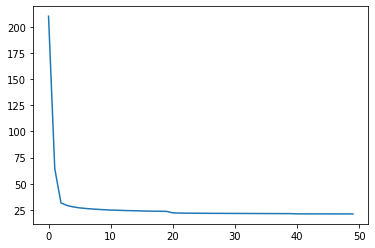

In [35]:
plt.plot(tot_loss)

In [32]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.046990


Original images


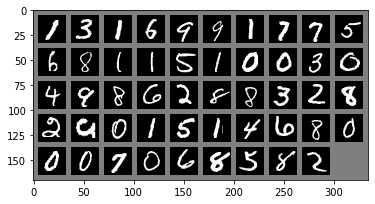

Autoencoder reconstruction:


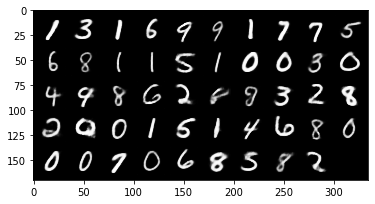

In [33]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)